# Coarse Graining Alanine Dipeptide: Force Matching via CGnet

In this tutorial, we use CGnet [1] to perform a force-matching analysis of alanine dipeptide in order to produce a coarse-grained force field. While this replicates the analysis in the original publication, note that the alanine dipeptide dataset is truncated and the tutorial therefore does _not_ represent a state of the art analysis; rather, it is designed to avoid time-consuming calculations and is an illustration of the basic pipeline.

## Setting up and loading data

First, we import all the necessary packages. Make sure that you've installed cgnet and all of its dependencies.

In [1]:
import numpy as np
import torch.nn as nn
import torch

from cgnet.feature import (GeometryFeature, GeometryStatistics,
                           MoleculeDataset, LinearLayer)
from cgnet.network import (CGnet, HarmonicLayer, ForceLoss, ZscoreLayer,
                           lipschitz_projection, dataset_loss, Simulation)

import mdtraj as md
from cgnet.molecule import CGMolecule

from torch.utils.data import DataLoader, RandomSampler
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
%matplotlib inline

# We specify the CPU as the training/simulating device here.
# If you have machine  with a GPU, you can use the GPU for
# accelerated training/simulation by specifying 
# device = torch.device('cuda')
device = torch.device('cpu')

Now we load our example dataset. The 10,000 data points are spaced at 10 picosecond intervals for a total of 100 nanoseconds of simulation time (compare with the CGnet paper [1], in which the same system is analyzed with a 1 microsecond trajectory at 1 picosecond intervals).

In [98]:
F = open('dataPP/CG_trj.gro', 'r')
frame = []
frames = []
count = 0
with open('dataPP/CG_trj.gro') as F:
    for line in F:
        P = line.split()
        if P[0] == '1LIG':
            x = float(P[3])
            y = float(P[4])
            z = float(P[5])
            frame.append([x,y,z])
        if P[0] == 'PP':
            count = count + 1
            if count > 1:
                frames.append(frame)
            frame = []

In [99]:
F = open('dataPP/force.xvg', 'r')
frameforce = []
framesforce = []
count = 0
with open('dataPP/force.xvg') as F:
    for line in F:
        P = line.split()
        for i in range(10):
            frameforce.append([float(P[3*i+1]),float(P[3*i + 2]),float(P[3*i + 3])])
        framesforce.append(frameforce)
        frameforce=[]

In [100]:
coords=np.array(frames,dtype='float32')
forces=np.array(framesforce,dtype='float32')

In [101]:
print("Coordinates size: {}".format(coords.shape))
print("Force: {}".format(forces.shape))

PP_data = MoleculeDataset(coords, forces, device=device)
print("Dataset length: {}".format(len(PP_data)))

Coordinates size: (101, 10, 3)
Force: (101, 10, 3)
Dataset length: 101


In [113]:
coords=coords[:,:5]
forces=forces[:,:5]

In [136]:
print("Coordinates size: {}".format(coords.shape))
print("Force: {}".format(forces.shape))

PP_data = MoleculeDataset(coords, forces, device=device)
print("Dataset length: {}".format(len(PP_data)))

Coordinates size: (101, 5, 3)
Force: (101, 5, 3)
Dataset length: 101


Each of the 10,000 data points has the three-dimensional coordinates and forces of each of the five coarse-grained beads (the five backbone atoms). We verify that the dimensions of the coordinates and forces are (number of frames, number of beads, number of dimensions) by printing their shapes.

Given correctly-shaped coordinates and corresponding forces, we can make a `MoleculeDataset` that will interface with our network.

## Gathering statistics

The harmonic contributions to the free energy from bonds and angles provide an important regularizing prior form on the energy learned by CGnet. Thus, we need to gather some statistics about our data's features. Specifically, we need the `get_bond_constants` method in the `GeometryStatistics` class.

First, we gather statistics specifically for bonds and angles, respectively. Using the `as_list` argument, we can get lists of statistics dictionaries that can be used to construct important prior energies for our CGnet model.

Note that _lists_ contain values, _keys_ contain tuples that specify a feature (e.g., a distance or an angle), and _indices_ contain integers used to locate certain features within _list_ or _key_ objects.

If we look at the dictionaries contained inside the _list_ objects, we see that the means, standard deviations, and harmonic constants are stored according to a tuple containing the bead indices (not the same as the _indices_ above!) of the involved atoms.

In [114]:
stats = GeometryStatistics(coords, backbone_inds='all',
                           get_all_distances=True,
                           get_backbone_angles=True,
                           get_backbone_dihedrals=True)

bond_list, bond_keys = stats.get_prior_statistics(features='Bonds', as_list=True)
bond_indices = stats.return_indices('Bonds')

angle_list, angle_keys = stats.get_prior_statistics(features='Angles', as_list=True)
angle_indices = stats.return_indices('Angles')
print("We have {} backbone beads, {} bonds, and {} angles.".format(
                        coords.shape[1], len(bond_list), len(angle_list)))
print("Bonds: ")
for key, stat in zip(bond_keys, bond_list):
    print("{} : {}".format(key, stat))
print("Angles: ")
for key, stat in zip(angle_keys, angle_list):
    print("{} : {}".format(key, stat))

We have 5 backbone beads, 4 bonds, and 3 angles.
Bonds: 
(0, 1) : {'mean': tensor(0.2629), 'std': tensor(0.0049), 'k': tensor(24855.9492)}
(1, 2) : {'mean': tensor(0.2627), 'std': tensor(0.0047), 'k': tensor(26758.9590)}
(2, 3) : {'mean': tensor(0.2618), 'std': tensor(0.0060), 'k': tensor(16603.5703)}
(3, 4) : {'mean': tensor(0.2637), 'std': tensor(0.0059), 'k': tensor(17041.3320)}
Angles: 
(0, 1, 2) : {'mean': tensor(2.2683), 'std': tensor(0.3577), 'k': tensor(4.6602)}
(1, 2, 3) : {'mean': tensor(2.1638), 'std': tensor(0.3481), 'k': tensor(4.9193)}
(2, 3, 4) : {'mean': tensor(2.1273), 'std': tensor(0.3764), 'k': tensor(4.2074)}


In addition to the harmonic constants for the bonds and angles, we want the zscores for every feature, including the dihedrals and the non-bond (i.e., non-adjacent) pairwise distances. Such zscore normalization is useful in speeding up convergence of CGnet parameters during training:

In [115]:
all_stats, _ = stats.get_prior_statistics(as_list=True)
num_feats = len(all_stats)
zscores, _ = stats.get_zscore_array()
print("We have {} statistics for {} features.".format(zscores.shape[0], zscores.shape[1]))

We have 2 statistics for 17 features.


## Hyperparameters

Next, we determine hyperparameters. Following the original paper [1], we use:

* 5 layers with 160 nodes each and tanh activation,
* random sampling from the dataset with a batch size of 512,
* Adam optimization with an intial learning rate of 0.003
* epochal multiplicative learning rate decay with decay constant $\gamma=0.3$, and
* L2 Lipschitz regularization via spectral normalization ($\lambda=4.0$) of each weight matrix.

In [126]:
# Hyperparameters

n_layers = 1
n_nodes = 50
activation = nn.Tanh()
batch_size = 50
learning_rate = 0.003
rate_decay = 0.3
lipschitz_strength = 4.0

## Setting up our network architecture and training

Now we are ready to start designing the architecture of our CGnet. We follow the optimal architecture in the CGnet paper [1], which consists of:

- a feature layer that outputs pairwise distances, angles, and dihedral angles from the Cartesian input trajectory that subtracts the means and divides by the standard deviations,
- hidden linear layers (bias term inclusive) with the first three followed by nonlinear activation, and
- harmonic prior layers that compute prior energies from bonds and angles.

The layers are stored in the list `layers` and the priors are stored in the list `priors`.

<img src="./figs/CGnet.png" width=600px>

In [127]:
# Start by scaling according to mean and standard deviation
layers = [ZscoreLayer(zscores)]

# The first hidden layer goes from number of features to 160
num_feat = len(all_stats)
layers += LinearLayer(num_feat, n_nodes, activation=activation)

# The inner hidden layers stay the same size
for _ in range(n_layers - 1):
    layers += LinearLayer(n_nodes, n_nodes, activation=activation)

# The last layer produces a single value
layers += LinearLayer(n_nodes, 1, activation=None)

# Construct prior energy layers
priors  = [HarmonicLayer(bond_indices, bond_list)]
priors += [HarmonicLayer(angle_indices, angle_list)]

For the feature layer, we create an instance of `GeometryFeature()`, which provides differentiable transformations from cartesian coordinate inputs into the CGnet to roto-translationally invariant internal features, such as angles, pairwise distances, and dihedrals (in fact, any set of general features can be passed to a `GeometryFeature()` initialization as a list of tuples of beads involved in the interaction).

By default, `GeometryFeature()` featurizes cartesian inputs into pairwise distances, angles, dihedral cosines, and dihedral sines. To make sure that any statistics used for priors or other preprocessing remain consistent with the ouput of the feature layer, the `stats.feature_tuples` attribute can be passed as an argument to `GeometryFeature()`.

In [128]:
feature_layer = GeometryFeature(feature_tuples=stats.feature_tuples, device=device)

With our architecture, we are ready to build our CGnet. Because we are recovering the coarse grain potential by matching the potential of mean force (PMF) from the all-atom + solvent model of alanine dipeptide, we imbue our network with the `ForceLoss()` criterion. We can look at our network by printing the object.

In [129]:
PP_net = CGnet(layers, ForceLoss(),
                 feature=feature_layer,
                 priors=priors).to(device)
print(PP_net)

CGnet(
  (arch): Sequential(
    (0): ZscoreLayer()
    (1): Linear(in_features=17, out_features=50, bias=True)
    (2): Tanh()
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
  (priors): Sequential(
    (0): HarmonicLayer()
    (1): HarmonicLayer()
  )
  (criterion): ForceLoss()
  (feature): GeometryFeature()
)


Now we set up our training tools. We will neglect cross-validation for brevity, but this is __not__ acceptable for real analysis. To do cross-validation, a `testloader` would be needed with validation data.

In [130]:
# Training tools

trainloader = DataLoader(PP_data, sampler=RandomSampler(PP_data),
                         batch_size=batch_size)
optimizer = torch.optim.Adam(PP_net.parameters(),
                             lr=learning_rate)
def regularizer(model, strength=lipschitz_strength):
        lipschitz_projection(model, strength=strength)
scheduler = MultiStepLR(optimizer,milestones=[1,2,3,4,5],
                        gamma=rate_decay)

num_epochs = 5
save_model = False
directory = '.' # to save model

epochal_train_losses = []
epochal_test_losses  = []
verbose = True
batch_freq = 10
epoch_freq = 1

## Train the model!

Now we can train the model.

In [131]:
for epoch in range(1, num_epochs+1):
    test_loss = 0.00
    train_loss = dataset_loss(PP_net, trainloader,
                              optimizer, regularizer,
                              verbose_interval=batch_freq)

    if verbose:
        if epoch % epoch_freq == 0:
            print(
                 "Epoch: {} | Train loss: {:.2f} | Test loss: {:.2f}\n".format(
                  epoch, train_loss, test_loss))
        epochal_train_losses.append(train_loss)
        #epochal_test_losses.append(test_loss)

    scheduler.step()
        
if save_model:
    torch.save(PP_net,"{}/PP_net.pt".format(directory))

Epoch: 1 | Train loss: 884918.10 | Test loss: 0.00

Epoch: 2 | Train loss: 884574.30 | Test loss: 0.00

Epoch: 3 | Train loss: 884550.18 | Test loss: 0.00

Epoch: 4 | Train loss: 884537.82 | Test loss: 0.00

Epoch: 5 | Train loss: 884533.87 | Test loss: 0.00



We can plot at the training loss over the epochs.

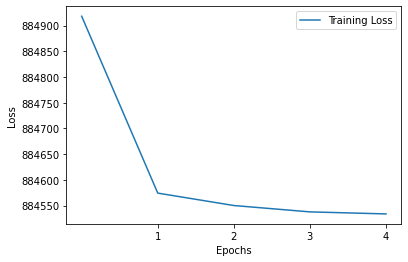

In [132]:
fig = plt.figure()
plt.plot(np.arange(0,len(epochal_train_losses),1),
         epochal_train_losses, label='Training Loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.xticks(np.arange(1,5))
plt.ylabel("Loss")
plt.show()

## Using the coarse-grained force field to simulate system dynamics

First we set up initial coordinates which will be used as the starting points for independent simulations.

We will run 1000 independent simulations seeded evenly the original dataset for 1000 timesteps each. These paramters can be changed below.

In [134]:
n_sims = 10
n_timesteps = 1000
save_interval = 10

In [123]:
for i in np.arange(0, 100, 100//n_sims):
    print(i)

0
10
20
30
40
50
60
70
80
90


In [135]:
initial_coords = np.concatenate([coords[i].reshape(-1,5,3)
                                 for i in np.arange(0, 100, 100//n_sims)],
                                 axis=0)
initial_coords = torch.tensor(initial_coords, requires_grad=True).to(device)
print("Produced {} initial coordinates.".format(len(initial_coords)))

sim = Simulation(PP_net, initial_coords, length=n_timesteps,
                 save_interval=save_interval, beta=stats.beta,
                 save_potential=True, device=device,
                 log_interval=10, log_type='print')

traj = sim.simulate()

Produced 10 initial coordinates.
Generating 10 simulations of length 1000 saved at 10-step intervals (Sat Mar  5 17:59:42 2022)


ValueError: Nan found in dihedral sines. Check your coordinates!)

## Analyze the simulation output

Now we want to see what our simulated coarse-grained dynamics are like. First we create an `mdtraj`-friendly [2] `CGMolecule` object.

In [15]:
names = ['C', 'N', 'CA', 'C', 'N']
resseq = [1, 2, 2, 2, 3]
resmap = {1: 'ACE', 2: 'ALA', 3: 'NME'}

ala2_cg = CGMolecule(names=names, resseq=resseq, resmap=resmap,
                          bonds='standard')

We can input our training and simulated coordinates in order to make `mdtraj` trajectories out of our data.

In [16]:
ala2_traj = ala2_cg.make_trajectory(coords)
ala2_simulated_traj = ala2_cg.make_trajectory(np.concatenate(traj, axis=0))

Using `mdtraj`, we compute the backbone $\phi$ and $\psi$ torsional angles of our reference and simulated systems.

In [17]:
_, phi = md.compute_phi(ala2_traj)
_, psi = md.compute_psi(ala2_traj)

_, sim_phi = md.compute_phi(ala2_simulated_traj)
_, sim_psi = md.compute_psi(ala2_simulated_traj)

For the reference coordinates, we compute the potential using our network. For the simulated coordinates, we saved the potential when we ran the simulation.

In [18]:
pot, _ = ala2_net.forward(torch.tensor(coords, requires_grad=True))
pot = pot.detach().numpy()
pot = pot - np.min(pot)

sim_pot = np.concatenate(sim.simulated_potential, axis=0)
sim_pot = sim_pot - np.min(sim_pot)

Finally, we plot the reference and simulation Ramachandran plots. Since we didn't train for very long, and because we used only a small amount of data, this shouldn't be too impressive.

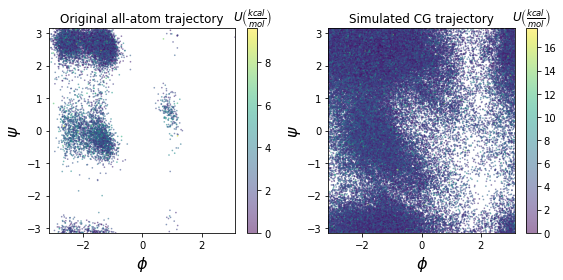

In [19]:
plt.subplots(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(phi.reshape(-1), psi.reshape(-1),
            c=pot.flatten(),
            cmap=plt.get_cmap("viridis"),alpha=0.5,s=0.5)
plt.xlabel(r'$\phi$',fontsize=16)
plt.ylabel(r'$\psi$',fontsize=16)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.title(r'Original all-atom trajectory')
clb=plt.colorbar()
clb.ax.set_title(r'$U\left(\frac{kcal}{mol}\right)$')

plt.subplot(1,2,2)
plt.scatter(sim_phi.reshape(-1), sim_psi.reshape(-1),
            c=sim_pot.flatten(),
            cmap=plt.get_cmap("viridis"),alpha=0.5,s=0.5)
plt.xlabel(r'$\phi$',fontsize=16)
plt.ylabel(r'$\psi$',fontsize=16)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.title('Simulated CG trajectory')
clb=plt.colorbar()
clb.ax.set_title(r'$U\left(\frac{kcal}{mol}\right)$')

plt.tight_layout()

We can also view the simulated free energy $F = U - TS$. To do this, we histogram the 2-dimensional dihedral trajectory and convert counts to populations $\pi_i$ for each bin $i$. Then, we transform the nonzero populations into energies according to $F_i = \beta^{-1}\log\pi_i$.

First we set up a graphing utility for our Ramachandran plots.

In [20]:
def plot_ramachandran(phi, psi, bins=60, cmap=plt.cm.magma):
    edges = np.array([[-np.pi, np.pi], [-np.pi, np.pi]])
    counts, _, _ = np.histogram2d(psi.reshape(-1),
                                  phi.reshape(-1),
                                  bins=bins,
                                  range=edges)
    populations = counts / np.sum(counts)
    
    # compute energies for only non-zero entries
    # 1/beta is approximately 0.6 kcal/mol at 300 K
    energies = -0.6*np.log(populations,
                           out=np.zeros_like(populations),
                           where=(populations > 0))
    
    # make the lowest energy slightly above zero
    energies = np.where(energies,
                        energies-np.min(energies[np.nonzero(energies)]) + 1e-6,
                        0)
    
    # mask the zero values from the colormap
    zvals_masked = np.ma.masked_where(energies == 0, energies)

    cmap.set_bad(color='white')
    img = plt.imshow(zvals_masked, interpolation='nearest', cmap = cmap)
    plt.gca().invert_yaxis()
    
    plt.xticks([-0.5, bins/2, bins], 
               [r'$-\pi$', r'$0$', r'$\pi$'])

    plt.yticks([-0.5, bins/2, bins],
               [r'$-\pi$', r'$0$', r'$\pi$'])
    
    plt.xlabel(r'$\phi$',fontsize=16)
    plt.ylabel(r'$\psi$',fontsize=16)
    
    cb=plt.colorbar()
    cb.ax.set_title(r'$\tilde{F}\left(\frac{kcal}{mol}\right)$')

Now we plot the free energies for the original and CG trajectories. Again, we expect this to look bad because we used only 1% of the dataset.

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()


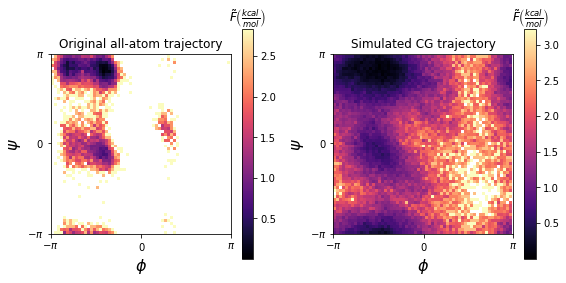

In [21]:
fig, axes = plt.subplots(figsize=(8,4))

plt.subplot(1,2,1)
plot_ramachandran(phi, psi)
plt.title('Original all-atom trajectory')

plt.subplot(1,2,2)
plot_ramachandran(sim_phi, sim_psi)
plt.title('Simulated CG trajectory')

plt.tight_layout()

#### *References*

[1] Wang, J., Olsson, S., Wehmeyer, C., Pérez, A., Charron, N. E., de Fabritiis, G., Noé, F., and Clementi, C. (2019). Machine Learning of Coarse-Grained Molecular Dynamics Force Fields. _ACS Central Science._ https://doi.org/10.1021/acscentsci.8b00913

[2] McGibbon, R. T., Beauchamp, K. A., Harrigan, M. P., Klein, C., Swails, J. M., Hernández, C. X., Schwantes, C. R., Wang, L.-P., Lane, T. J., and Pande, V. S. (2015). MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. _Biophys J._ http://dx.doi.org/10.1016/j.bpj.2015.08.015